<a href="https://colab.research.google.com/github/pthpth/NYU-DL/blob/main/Copy_of_11_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST,StanfordCars
from matplotlib import pyplot as plt

In [ ]:
import matplotlib as mpl
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1, title='Training data (x, y)'):
    X = X.cpu()
    y = y.cpu()
    s = plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.35'
    plt.axvline(0, ymin=_m, color=_c, lw=1)
    plt.axhline(0, xmin=_m, color=_c, lw=1)
    plt.title(title)
    return s


def plot_model(X, y, model):
    model.cpu()
    mesh = torch.arange(-1.1, 1.1, 0.01)
    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)
        Z = model(data)
    Z = Z.argmax(dim=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    plt.title('Model decision boundaries')


def plot_embeddings(X, y, model, zoom=10):
    # Use forward hook to get internal embeddings of the second last layer
    layer_outputs = {}

    def get_layer_outputs(name):
        def hook(model, input, output):
            layer_outputs[name] = output

        return hook

    layer = model[-2]

    if layer.__class__ == torch.nn.modules.linear.Linear and layer.out_features == 2:
        layer.register_forward_hook(get_layer_outputs("low_dim_embeddings"))
        with torch.no_grad():
            model(X)  # pass data through model to populate layer_outputs
        plot_data(
            layer_outputs["low_dim_embeddings"],
            y,
            zoom=zoom,
            title="Low dim embeddings",
        )
        last_layer = model[-1]
        mesh = torch.arange(-1.1, 1.1, 0.01) * zoom
        xx, yy = torch.meshgrid(mesh, mesh, indexing="ij")
        with torch.no_grad():
            data = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)
            Z = last_layer(data)
        Z = Z.argmax(dim=1).reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3, levels=y.max().item())
    else:
        print(
            "Cannot plot: second-last layer is not a linear layer"
            f" with output in R^2 (it is {layer})"
        )


def acc(l, y):
    score, predicted = torch.max(l, 1)
    return (y == predicted).sum().float() / len(y)


def overwrite(string):
    print(string)
    clear_output(wait=True)


def plot_2d_energy_levels(X, y, energy, v=None, l=None):
    xx, yy, F, k, K = energy
    if not v: vmin = vmax = None
    else: vmin, vmax = v
    if not l: levels = None
    else: levels = torch.arange(l[0], l[1], l[2])
    plt.figure(figsize=(12, 10))
    plt.pcolormesh(xx, yy, F, vmin=vmin, vmax=vmax)
    plt.colorbar()
    cnt = plt.contour(xx, yy, F, colors='w', linewidths=1, levels=levels)
    plt.clabel(cnt, inline=True, fontsize=10, colors='w')
    s = plot_data(X, y)
    plt.legend(*s.legend_elements(), title='Classes', loc='lower right')
    plt.axvline(color='0.55', lw=1)
    plt.axhline(color='0.55', lw=1)
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    ȳ = torch.zeros(K).int(); ȳ[k] = 1
    plt.title(f'Free energy F(x, y = {ȳ.tolist()})')


def plot_3d_energy_levels(X, y, energy, v=None, l=None, cbl=None):
    xx, yy, F, k, K = energy
    if not v: vmin = vmax = None
    else: vmin, vmax = v
    if not l: levels = None
    else: levels = torch.arange(l[0], l[1], l[2])
    fig = plt.figure(figsize=(9.5, 6), facecolor='k')
    ax = fig.add_subplot(projection='3d')
    cnt = ax.contour(xx, yy, F, levels=levels, vmin=vmin, vmax=vmax)
    ax.scatter(X[:,0], X[:,1], zs=0, c=y, cmap=plt.cm.Spectral)
    ax.xaxis.set_pane_color(color=(0,0,0))
    ax.yaxis.set_pane_color(color=(0,0,0))
    ax.zaxis.set_pane_color(color=(0,0,0))

    vmin, vmax = cnt.get_clim()
    ax.set_zlim3d(vmin, vmax)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    if not cbl: cbl = l
    else: cbl = torch.arange(cbl[0], cbl[1], cbl[2])
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cnt.cmap)
    sm.set_array([])
    fig.colorbar(sm, ticks=cbl)
    ȳ = torch.zeros(K).int(); ȳ[k] = 1
    plt.title(f'Free energy F(x, y = {ȳ.tolist()})')
    plt.tight_layout()
    return fig, ax

In [ ]:
# Displaying routine

def display_images(in_, out, n=1, label='', count=False, energy=None):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            c = 4 * N + i
            if count: plt.title(str(c), color='w')
            if count and energy is not None: plt.title(f'{c}, e={energy[c].item():.2f}', color='w')


In [ ]:
# Set random seeds

torch.manual_seed(1)
# torch.cuda.manual_seed(1)

In [ ]:
from torchvision.datasets.stanford_cars import StanfordCars
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    FashionMNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST('./data', download=True,transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
# Defining the model

d = 256

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Sequential(
            # nn.Linear(784, d ** 2),
            # nn.ReLU(),
            # nn.Linear(d ** 2, d * 2)
            nn.Conv2d(1,4,4),
            nn.ReLU(),
            nn.Conv2d(4,8,4),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(968,d*2)
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(d,8,4,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8,4,4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4,2,4,stride=2,padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(2,1,4,stride=2,padding=1),
            nn.Sigmoid()
        )
        self.encoder2 = nn.Sequential(
            # nn.Linear(784, d ** 2),
            # nn.ReLU(),
            # nn.Linear(d ** 2, d * 2)
            nn.Conv2d(1,4,4),
            nn.ReLU(),
            nn.Conv2d(4,8,4),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(968,d*2)
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(d,8,4,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8,4,4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4,2,4,stride=2,padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(2,1,4,stride=2,padding=1),
            nn.Sigmoid()
        )
        self.encoder3 = nn.Sequential(
            # nn.Linear(784, d ** 2),
            # nn.ReLU(),
            # nn.Linear(d ** 2, d * 2)
            nn.Conv2d(1,4,4),
            nn.ReLU(),
            nn.Conv2d(4,8,4),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(968,d*2)
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(d,8,4,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8,4,4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4,2,4,stride=2,padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(2,1,4,stride=2,padding=1),
            nn.Sigmoid()
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, y):
        mu_logvar = self.encoder1(y).view(-1,2,d)
        mu1= mu_logvar[:, 0, :]
        logvar1 = mu_logvar[:, 1, :]
        z = self.reparameterise(mu1, logvar1).view(-1,d,1,1)
        y=self.decoder1(z)
        mu_logvar = self.encoder2(y).view(-1,2,d)
        mu2= mu_logvar[:, 0, :]
        logvar2 = mu_logvar[:, 1, :]
        z = self.reparameterise(mu2+mu1, logvar2+logvar1).view(-1,d,1,1)
        y=self.decoder2(z)
        mu_logvar = self.encoder3(y).view(-1,2,d)
        mu3= mu_logvar[:, 0, :]
        logvar3 = mu_logvar[:, 1, :]
        z = self.reparameterise(mu3+mu2+mu1, logvar3+logvar2+logvar1).view(-1,d,1,1)
        y=self.decoder3(z)
        # print(y.shape)
        return y,mu1,logvar1,mu2+mu1,logvar2+logvar1,mu3+mu2+mu1,logvar3+logvar2+logvar1
model = VAE().to(device)

In [ ]:
# test=torch.ones((1,1,28,28)).view(1,1,28,28)
# print(test.shape)
# model(test)

In [ ]:

# Setting the optimiser

learning_rate = 1e-3*5

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(ỹ, y, mu1, logvar1,mu2,logvar2,mu3,logvar3):
    BCE = nn.functional.binary_cross_entropy(
        ỹ, y, reduction='sum'
    )
    KLD = (0.5 * torch.sum(logvar1.exp() - logvar1 - 1 + mu1.pow(2)) + 2 * torch.sum(logvar2.exp() - logvar2 - 1 + mu2.pow(2)) + 5 * torch.sum(logvar3.exp() - logvar3 - 1 + mu3.pow(2)))/15

    return BCE + KLD,BCE,KLD

Average loss: 579.6334442708334 BCE Loss: 576.1374 KLD Loss: 3.4960
====> Epoch: 1 Average loss: 346.9845 BCE Loss: 330.3101 KLD Loss: 16.6743
Average loss: 300.94537747395833 BCE Loss: 285.9505 KLD Loss: 14.9949
====> Epoch: 2 Average loss: 286.1830 BCE Loss: 268.7467 KLD Loss: 17.4363
Average loss: 267.97810498046874 BCE Loss: 252.1307 KLD Loss: 15.8474
====> Epoch: 3 Average loss: 267.6961 BCE Loss: 250.9523 KLD Loss: 16.7439
Average loss: 257.0163426106771 BCE Loss: 241.5570 KLD Loss: 15.4593
====> Epoch: 4 Average loss: 258.5880 BCE Loss: 241.4533 KLD Loss: 17.1348
Average loss: 253.26384436848957 BCE Loss: 237.1212 KLD Loss: 16.1426
====> Epoch: 5 Average loss: 253.2584 BCE Loss: 235.1250 KLD Loss: 18.1334
Average loss: 249.918712109375 BCE Loss: 233.9126 KLD Loss: 16.0061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


====> Epoch: 6 Average loss: 250.3180 BCE Loss: 231.0005 KLD Loss: 19.3175
Average loss: 249.84099853515625 BCE Loss: 231.8911 KLD Loss: 17.9499
====> Epoch: 7 Average loss: 248.8457 BCE Loss: 227.9365 KLD Loss: 20.9091
Average loss: 248.63424677734375 BCE Loss: 230.2234 KLD Loss: 18.4109
====> Epoch: 8 Average loss: 245.1610 BCE Loss: 222.4388 KLD Loss: 22.7222
Average loss: 249.62378046875 BCE Loss: 230.2053 KLD Loss: 19.4185
====> Epoch: 9 Average loss: 242.6657 BCE Loss: 217.6447 KLD Loss: 25.0211
Average loss: 249.7206181640625 BCE Loss: 228.2694 KLD Loss: 21.4513
====> Epoch: 10 Average loss: 240.3979 BCE Loss: 212.9654 KLD Loss: 27.4325
Average loss: 251.60839036458333 BCE Loss: 229.6313 KLD Loss: 21.9771


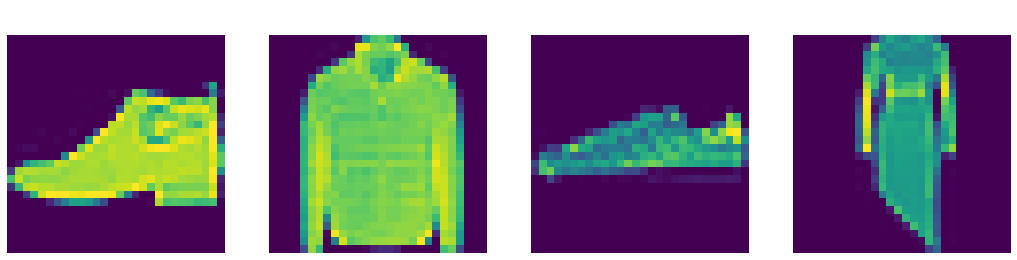

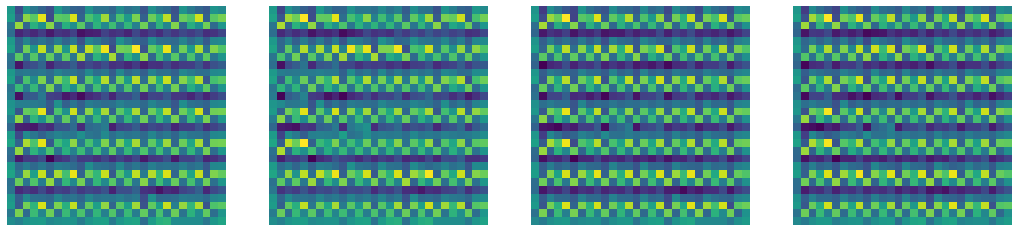

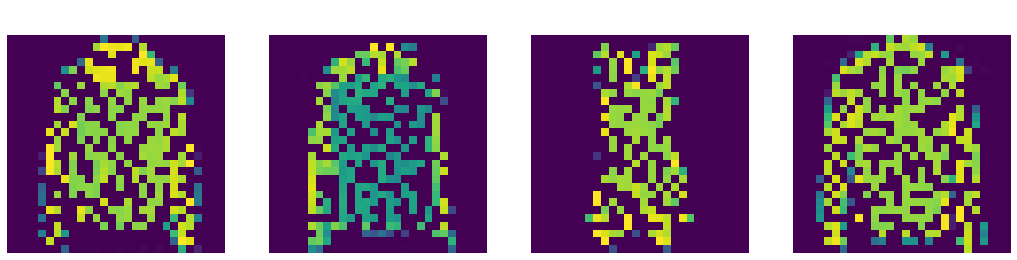

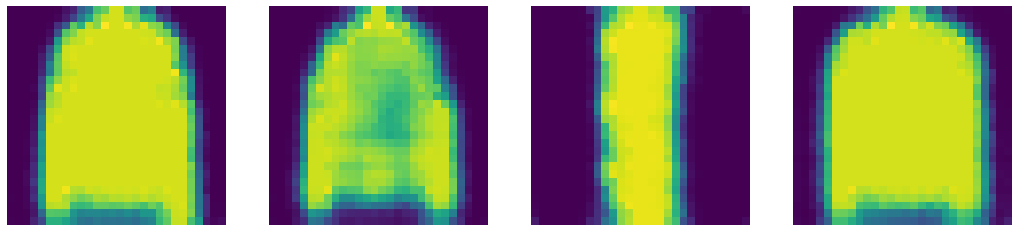

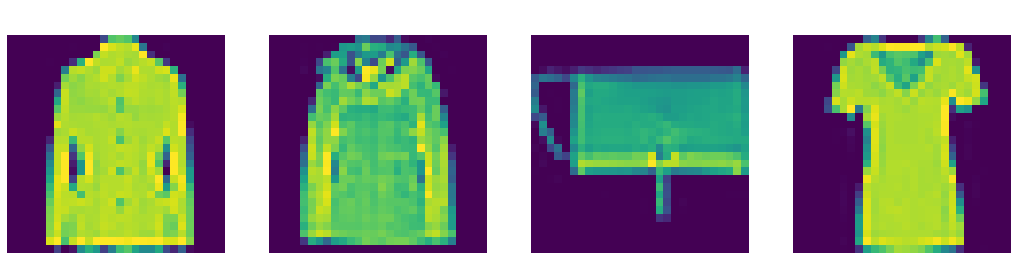

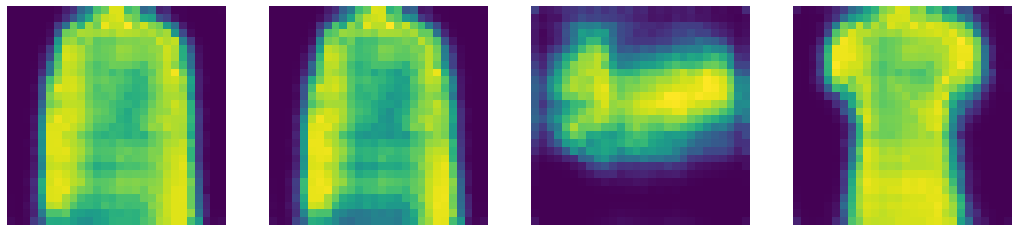

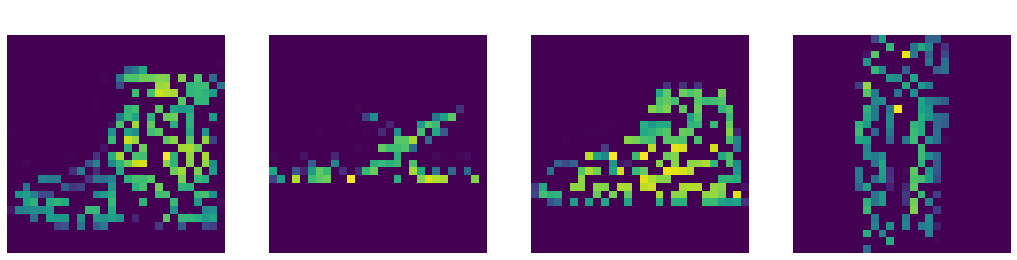

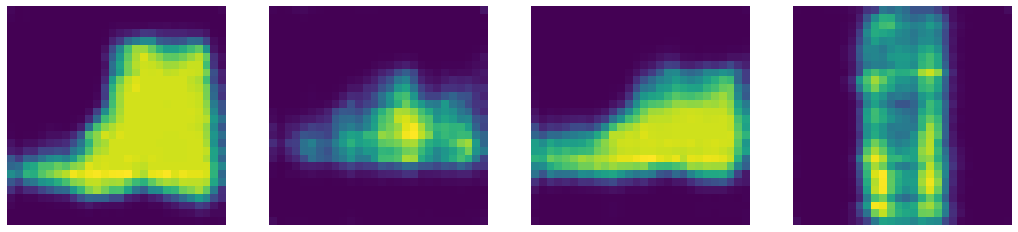

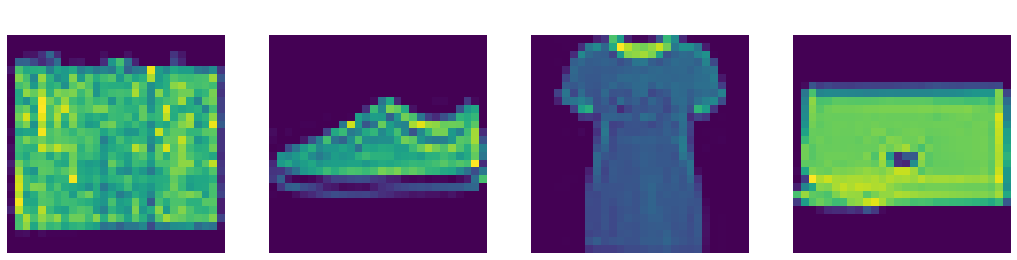

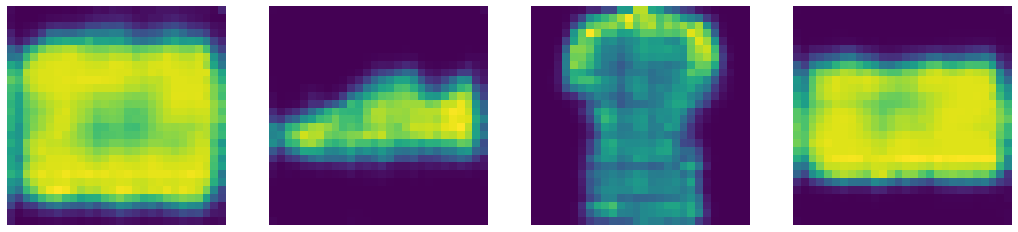

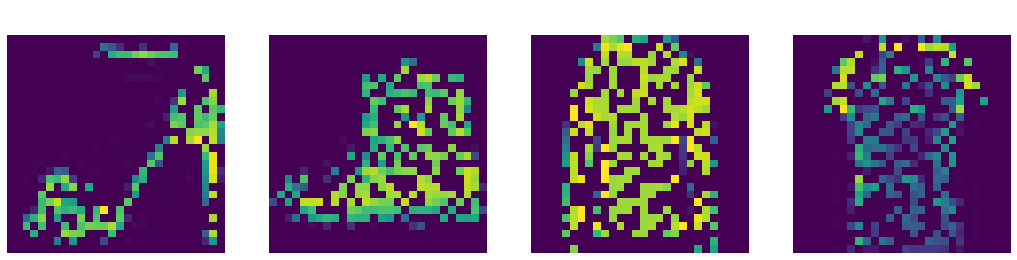

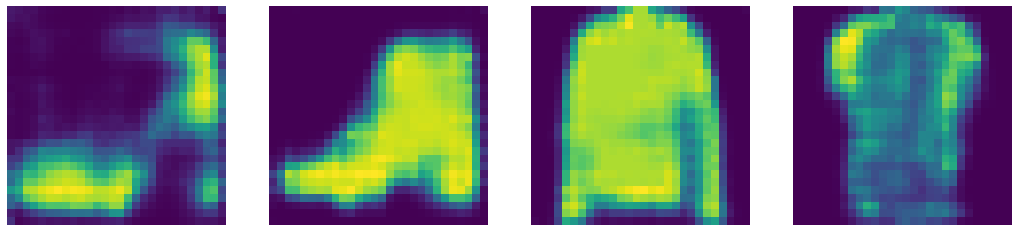

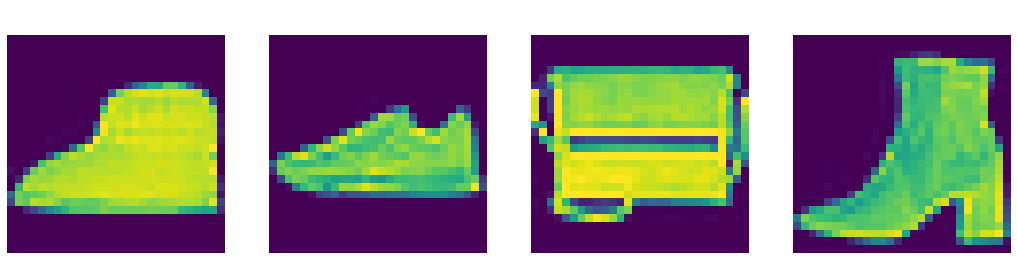

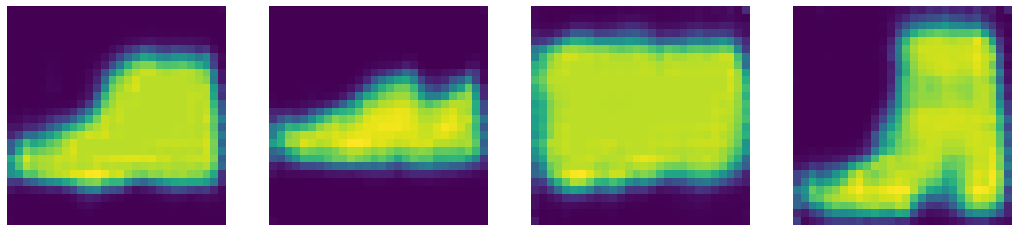

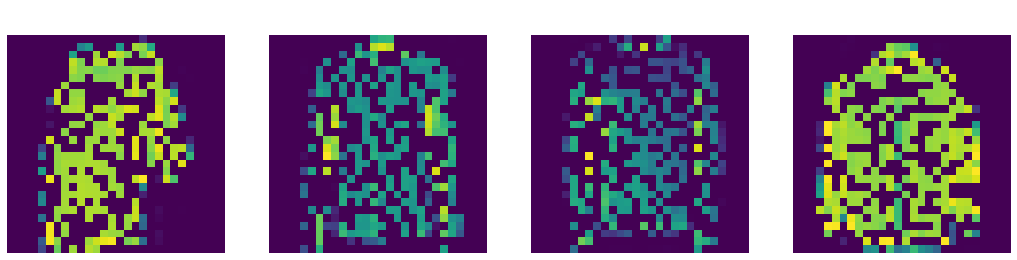

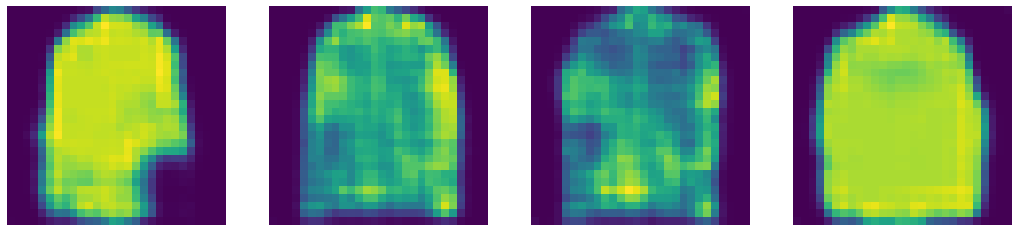

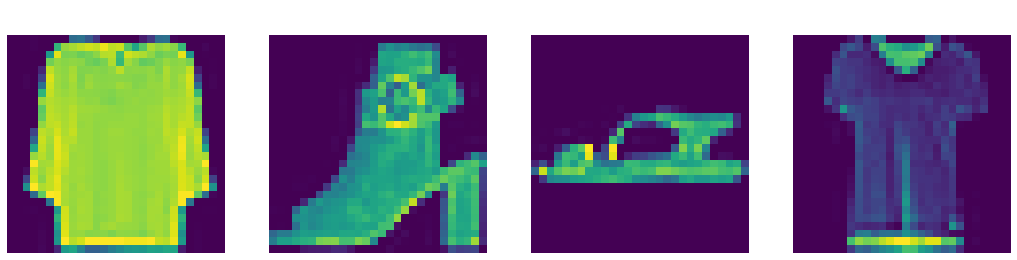

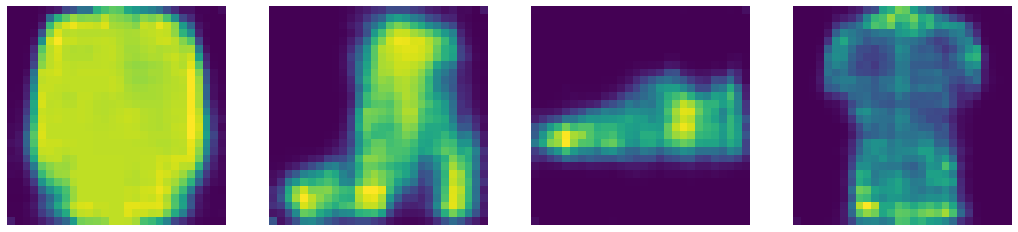

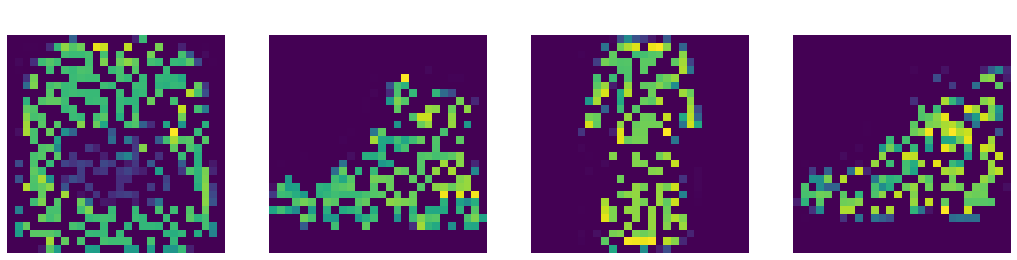

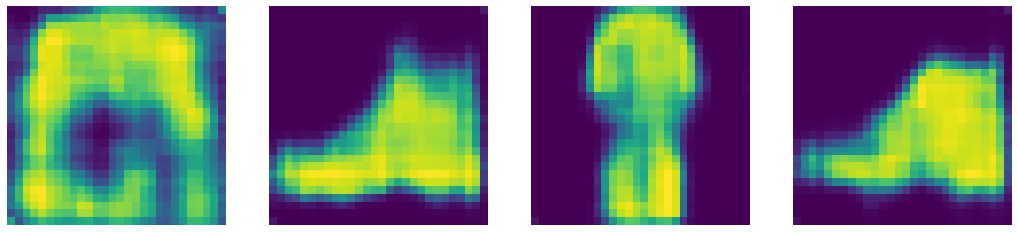

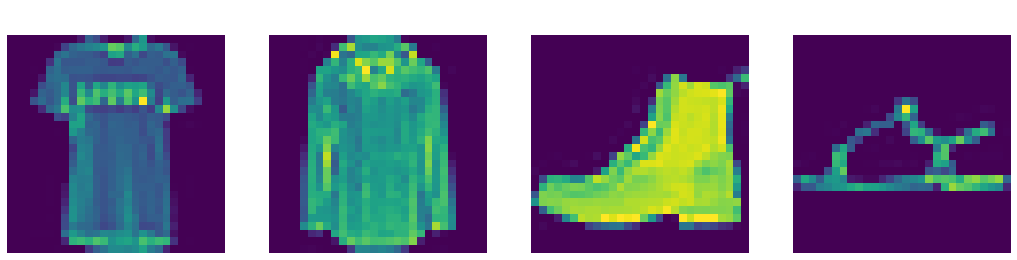

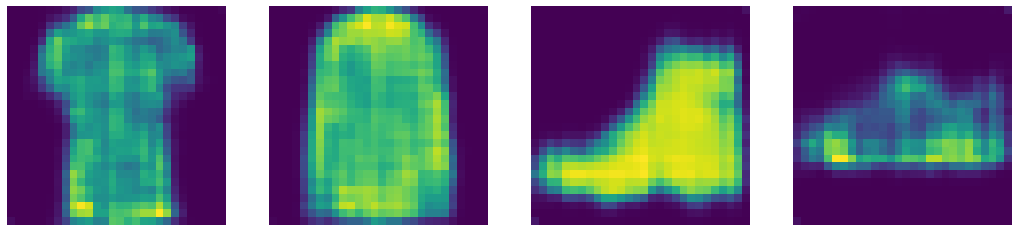

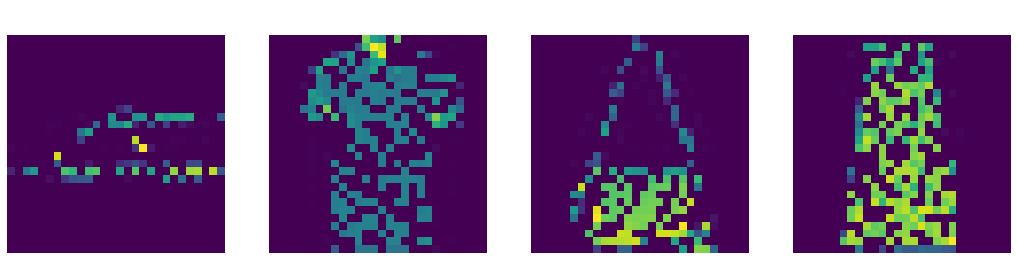

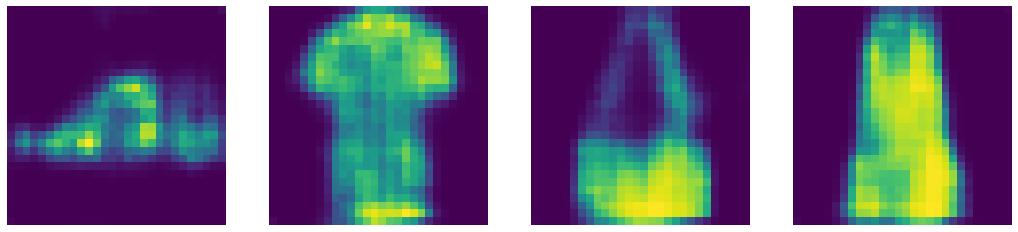

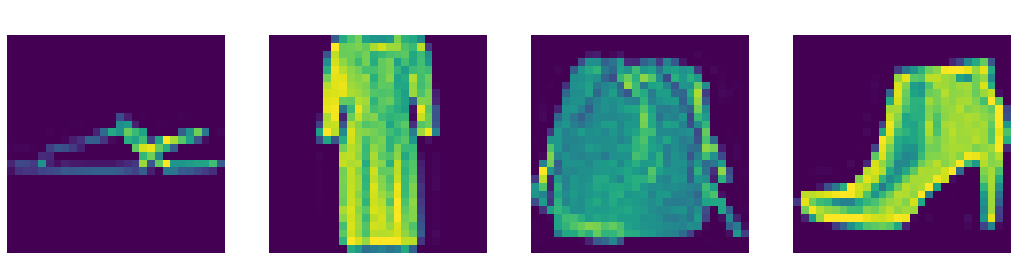

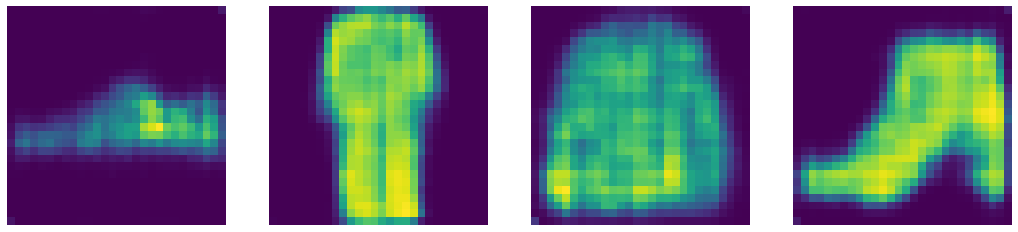

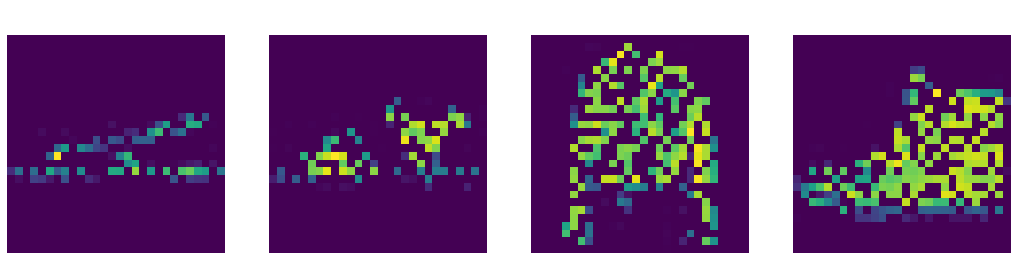

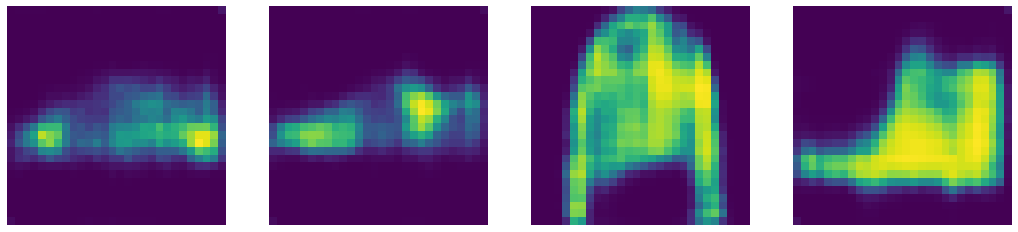

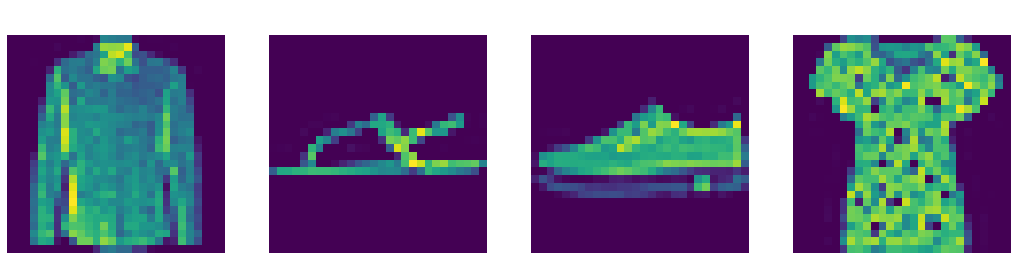

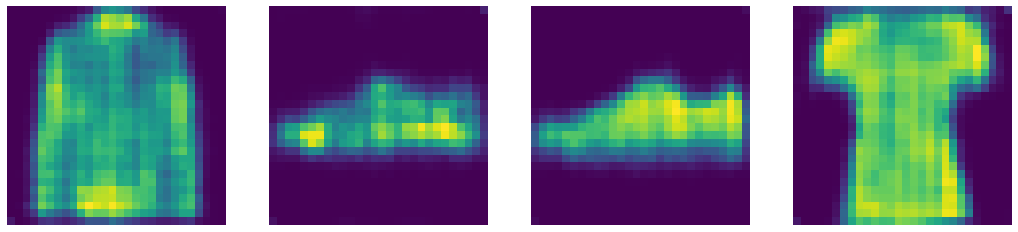

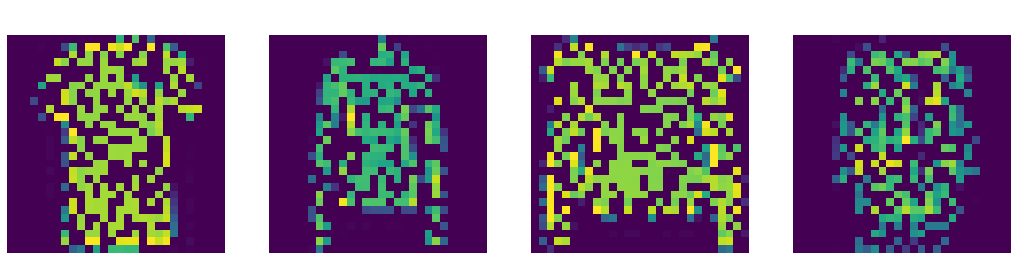

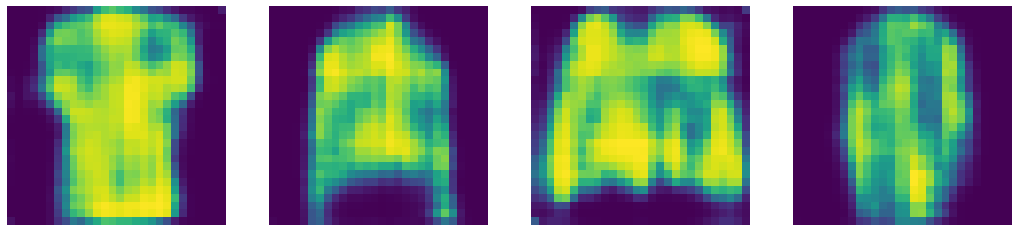

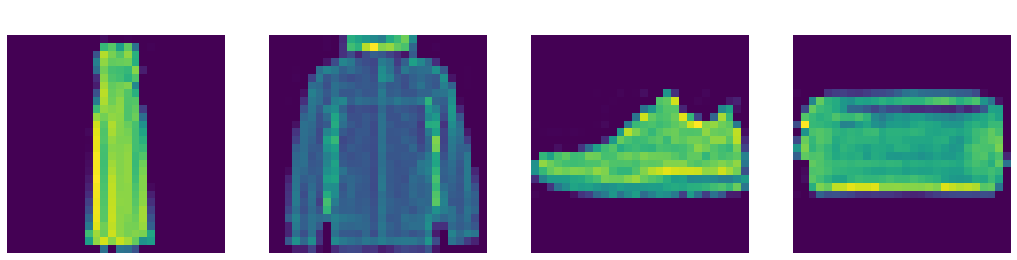

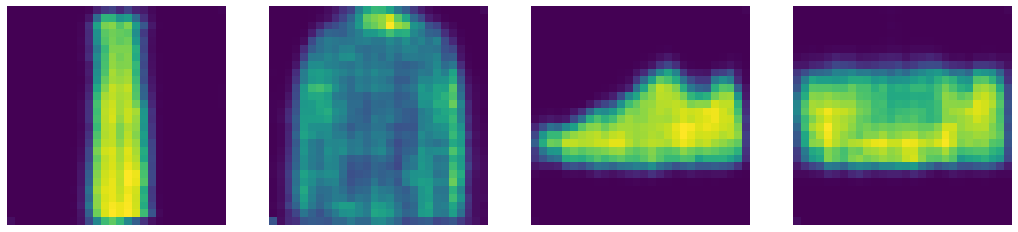

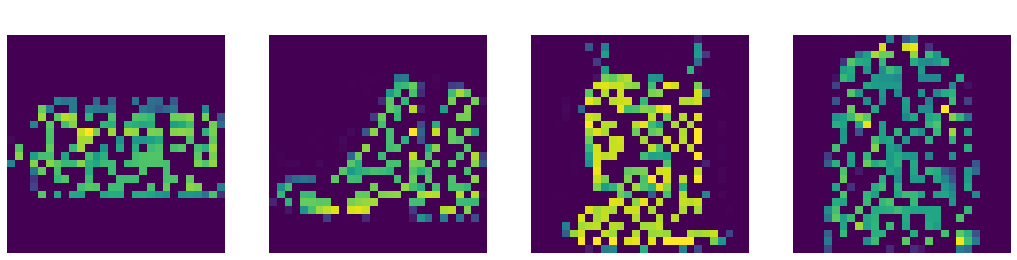

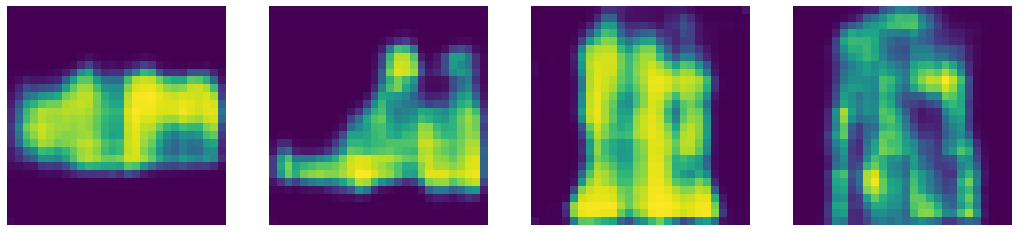

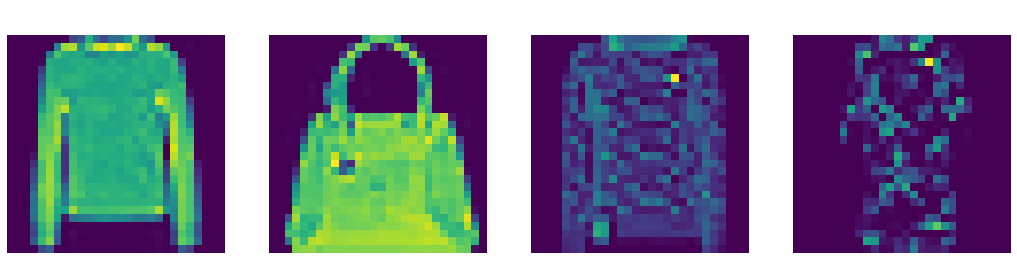

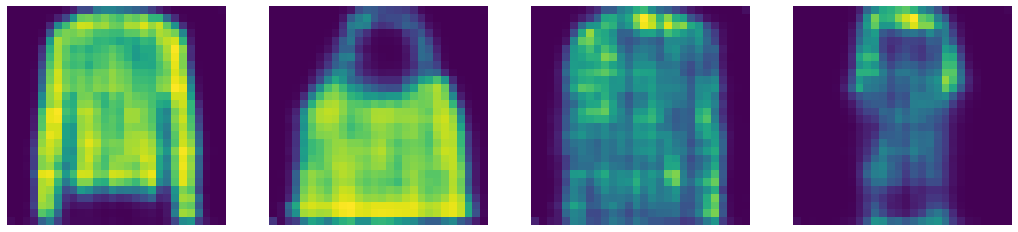

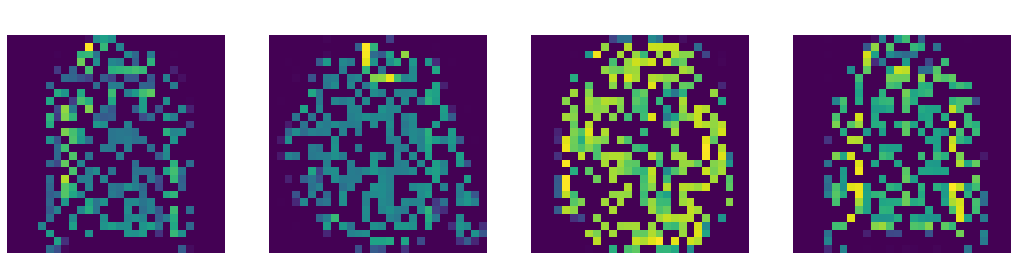

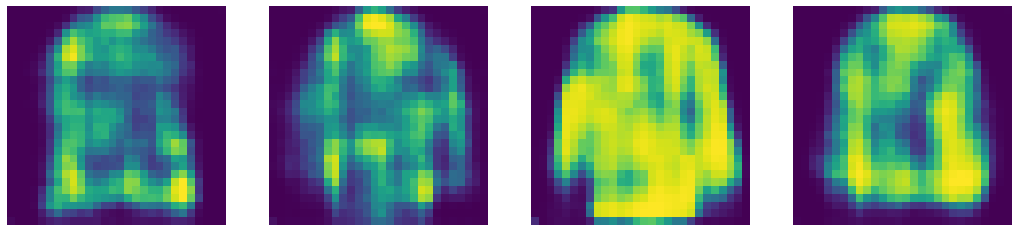

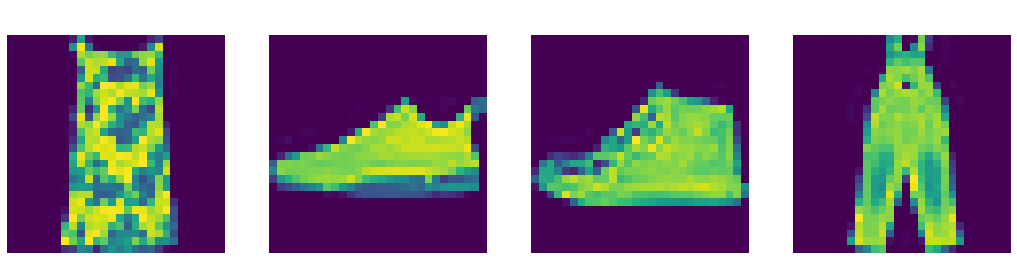

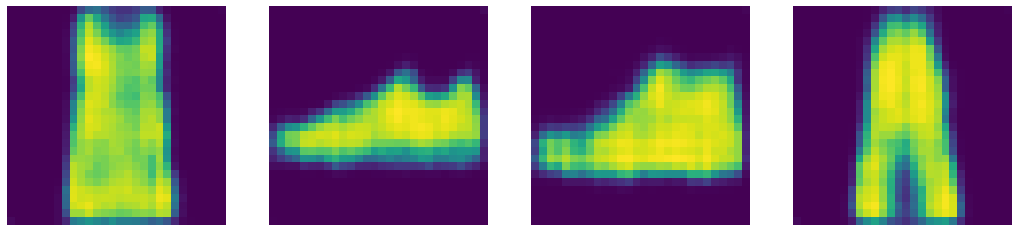

In [ ]:
# Training and testing the VAE
do=nn.Dropout()
epochs = 10
codes = dict(μ=list(), logσ2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        bcs=0
        kls=0
        for y, _ in train_loader:
            y = y.to(device)
            y=y.view(-1,1,28,28)
            noise=do(torch.ones(y.shape)).to(device)
            y=(y*noise).to(device)
            # ===================forward=====================
            ỹ, mu1, logvar1,mu2,logvar2,mu3,logvar3 = model(y)
            loss,bc,kl = loss_function(ỹ, y, mu1, logvar1,mu2,logvar2,mu3,logvar3)
            train_loss += loss.item()
            bcs+=bc.item()
            kls+=kl.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f} BCE Loss: {bcs / len(train_loader.dataset):.4f} KLD Loss: {kls / len(train_loader.dataset):.4f}')
        display_images(y,ỹ)
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        bcs=0
        kls=0
        for y, x in test_loader:
            y = y.to(device)
            y=y.view(-1,1,28,28)
            # ===================forward=====================
            ỹ, mu1, logvar1,mu2,logvar2,mu3,logvar3 = model(y)
            # print(ỹ.shape)
            # print(y.shape)
            loss,bc,kl = loss_function(ỹ, y, mu1, logvar1,mu2,logvar2,mu3,logvar3)
            test_loss+=loss.item()
            bcs+=bc.item()
            kls+=kl.item()
            # =====================log=======================
            means.append(mu3.detach())
            logvars.append(logvar3.detach())
            labels.append(x.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'Average loss: {test_loss} BCE Loss: {bcs / len(test_loader.dataset):.4f} KLD Loss: {kls / len(test_loader.dataset):.4f}')
    display_images(y, ỹ, 1, f'Epoch {epoch}')

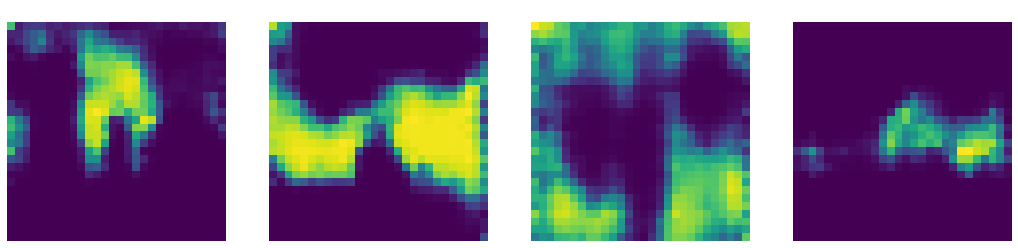

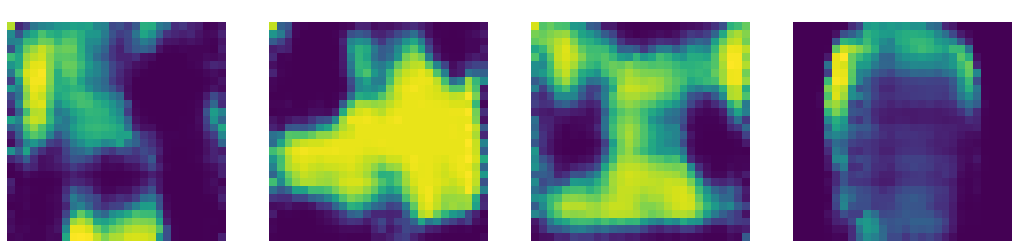

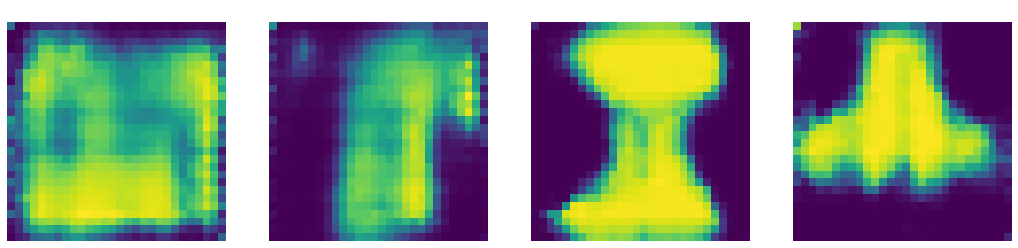

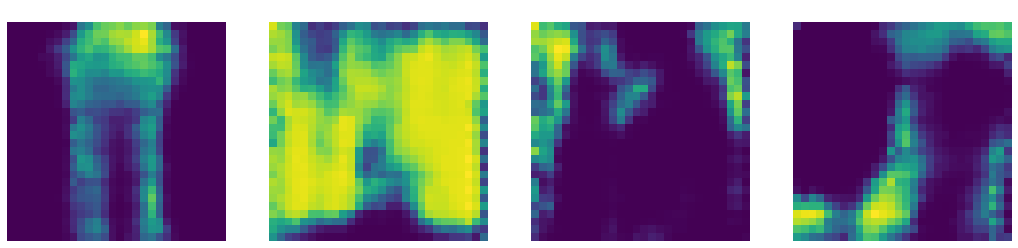

In [ ]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device).view(-1,d,1,1)
sample = model.decoder3(z)
display_images(None, sample, N // 4, count=True)

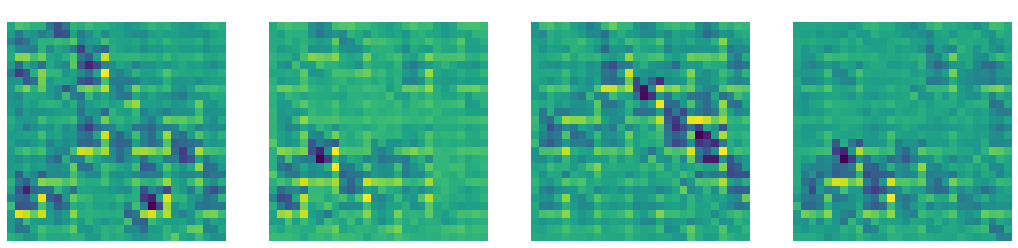

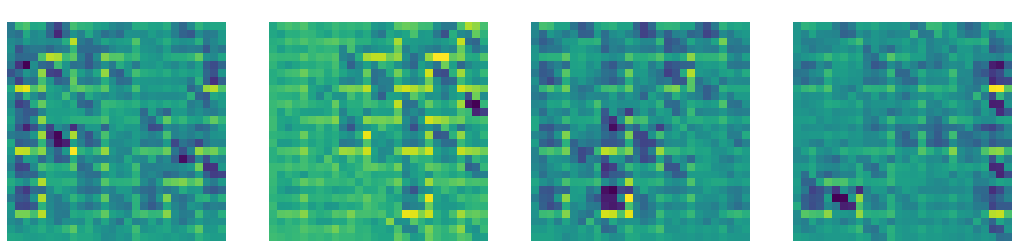

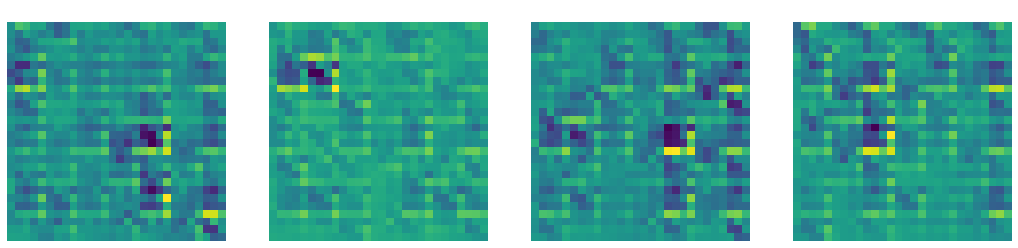

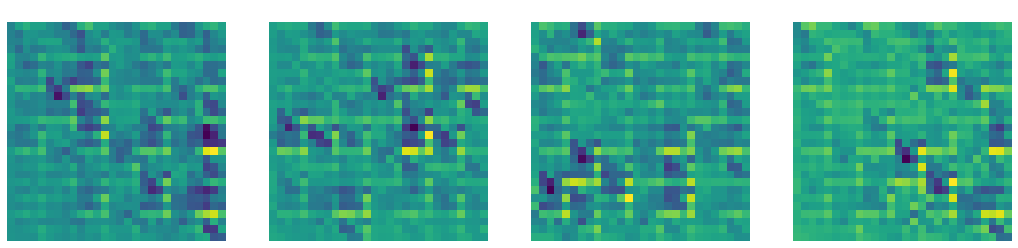

In [ ]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device).view(-1,d,1,1)
sample = model.decoder2(z)
display_images(None, sample, N // 4, count=True)

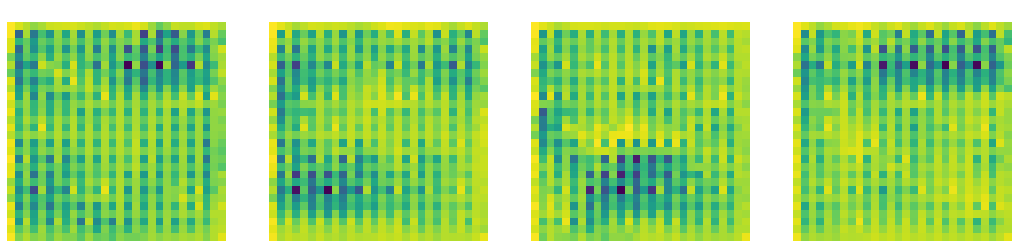

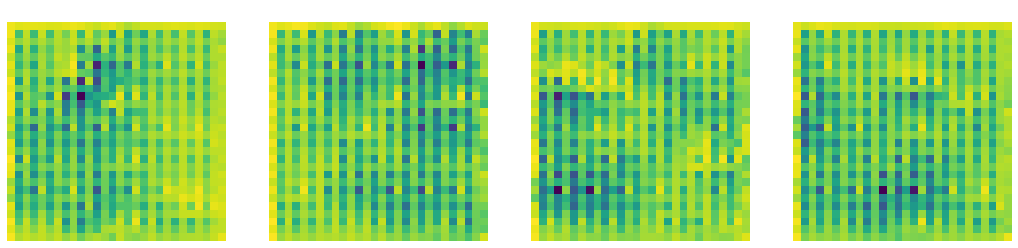

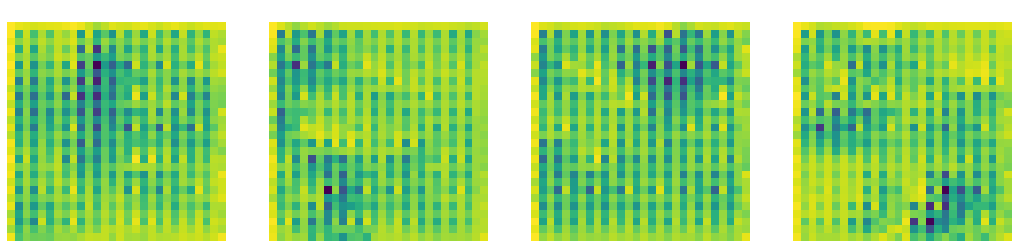

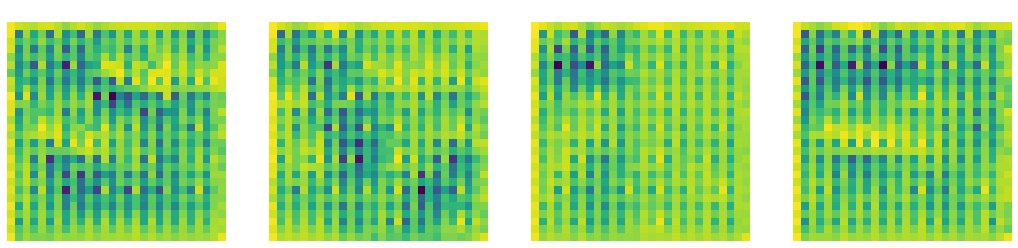

In [ ]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device).view(-1,d,1,1)
sample = model.decoder1(z)
display_images(None, sample, N // 4, count=True)

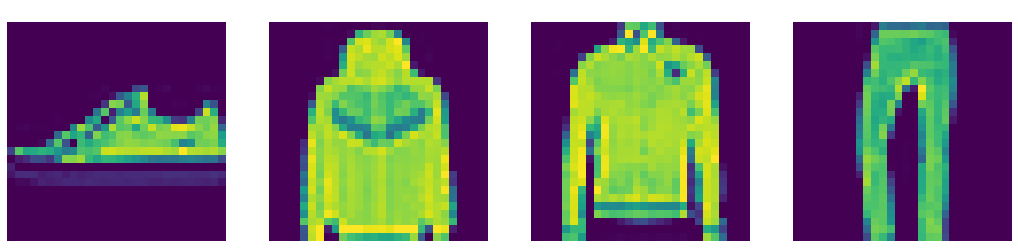

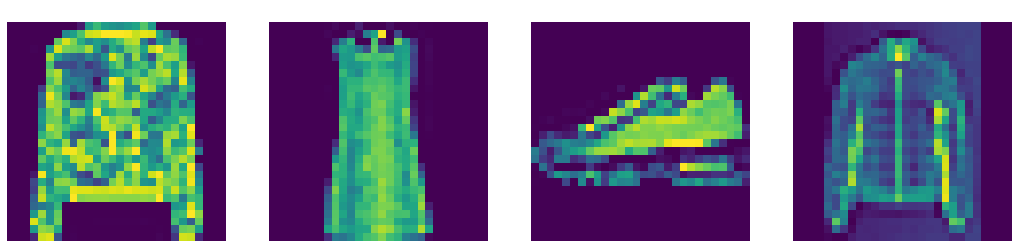

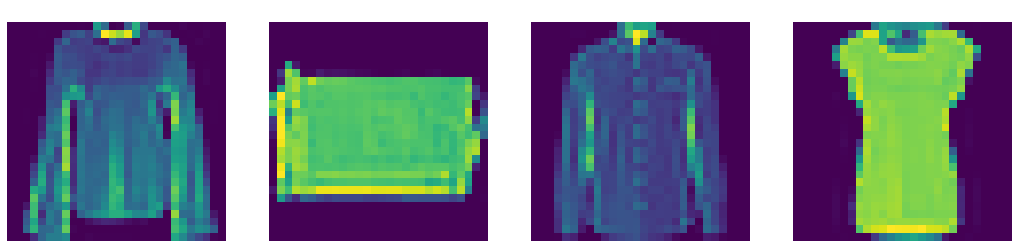

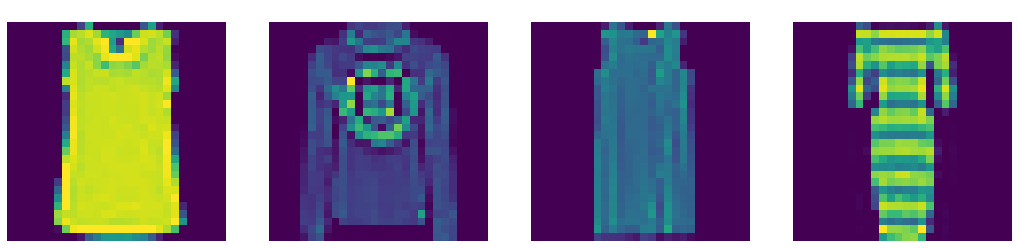

In [ ]:
# Display last test batch
with torch.no_grad():
    ỹ = model(y)[0].view(-1, 28, 28)
energy = y.squeeze().sub(ỹ).pow(2).sum(dim=(1,2))
display_images(None, y, 4, count=True, energy=energy)

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 9
print(mu[:,A].shape)
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0).view(-1,1,28,28))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1],
    sample.data[0],
    sample.data[1],
    y[A].data.view(-1) - sample.data[0],
    y[B].data.view(-1) - sample.data[1]
)), 0), 2)

torch.Size([16])


RuntimeError: ignored

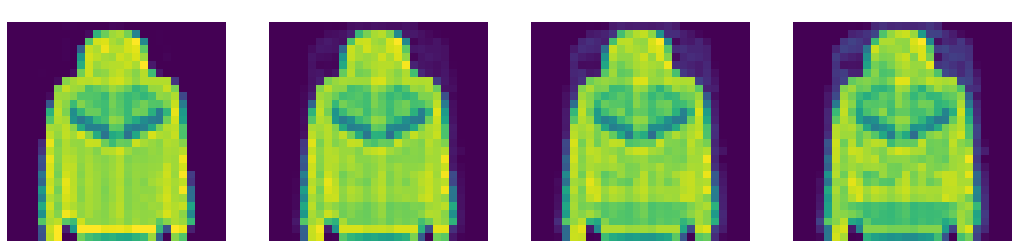

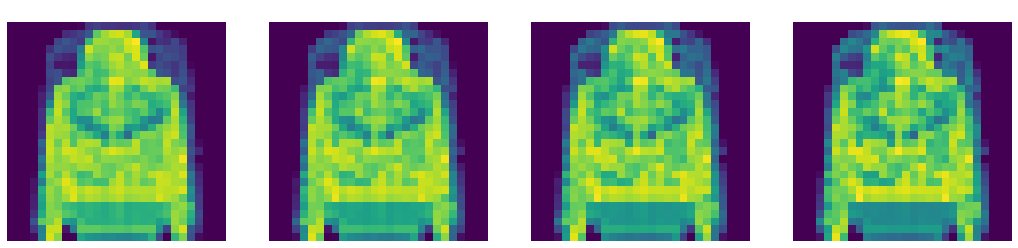

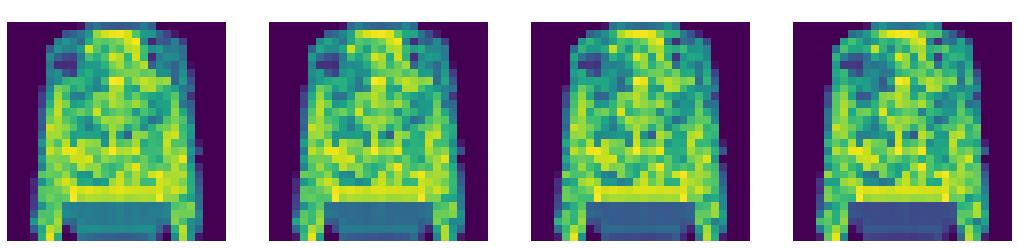

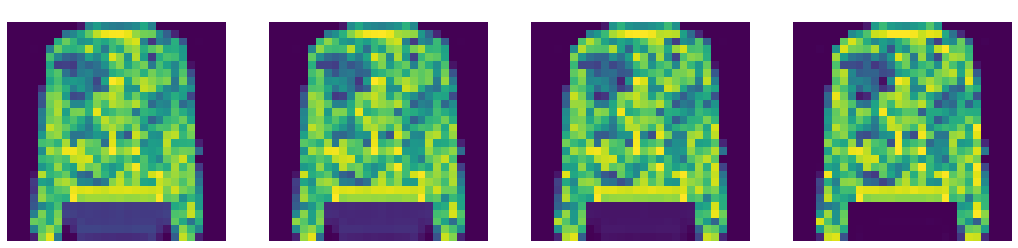

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 1024).to(device)
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
      code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
# samples = model.decoder(code)
display_images(None, samples, N // 4, count=True)

In [ ]:
print(sample.shape)
ẏ = sample[0]
with torch.no_grad():
    ỹ = model(ẏ)[0]
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((ẏ).view(28, 28).detach().numpy())
plt.subplot(122), plt.imshow((ỹ).view(28, 28).detach().numpy())

torch.Size([2, 1, 28, 28])


RuntimeError: ignored

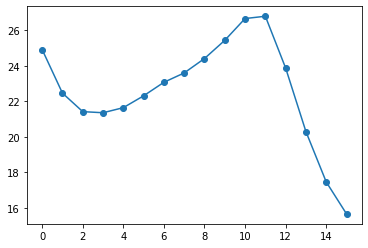

In [ ]:
N = 16
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
with torch.no_grad():
    reconstructions = model(samples)[0].view(-1, 28, 28)

# plt.title(f'{A = }, {B = }')
plt.plot(samples.sub(reconstructions).pow(2).sum(dim=(1,2)), '-o')

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    Y.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1].detach().cpu()))
    X.append(codes['x'][epoch][:N])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

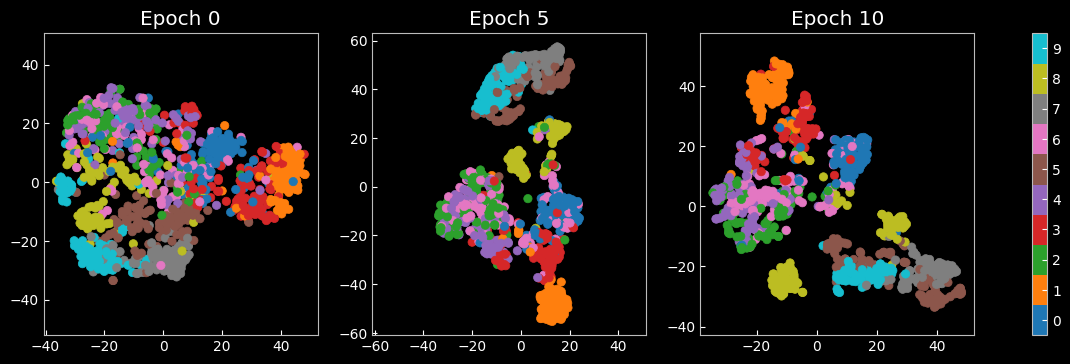

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=X[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)